In-sample through 2025-11-28. Forecast steps: 12 (BME).

Point forecast at final horizon (%, rounded):
            0.25Y  0.5Y    1Y    2Y    3Y    5Y    7Y   10Y
2026-11-30   2.83  2.86  2.91  3.02  3.11  3.29  3.45  3.67


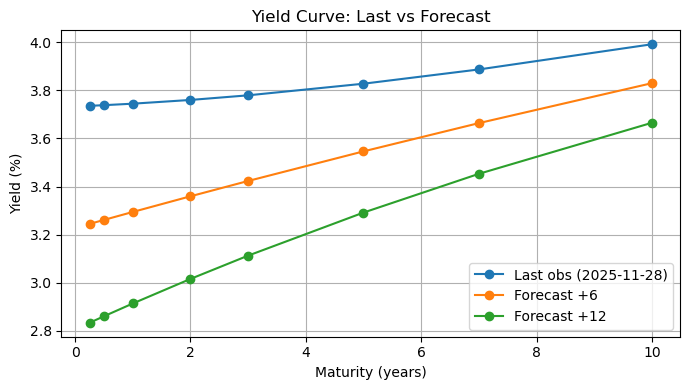


Final-horizon baseline vs +100bp parallel shock (%, rounded):
       baseline  +100bp
0.25Y      2.83    3.83
0.5Y       2.86    3.86
1Y         2.91    3.91
2Y         3.02    4.02
3Y         3.11    4.11
5Y         3.29    4.29
7Y         3.45    4.45
10Y        3.67    4.67


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from typing import List, Dict

# ----------------------------
# Config
# ----------------------------
FRED_API_KEY = "a8837523b7c200b627e6e1f1a7275566"

# FRED series IDs and maturities in years
SERIES = {
    "DGS1MO": 1 / 12,
    "DGS3MO": 3 / 12,
    "DGS6MO": 6 / 12,
    "DGS1": 1.0,
    "DGS2": 2.0,
    "DGS3": 3.0,
    "DGS5": 5.0,
    "DGS7": 7.0,
    "DGS10": 10.0,
    "DGS20": 20.0,
    "DGS30": 30.0,
}

# ----------------------------
# Data: FRED fetch
# ----------------------------
def _fetch_series_requests(series_id: str, start: str = "1990-01-01") -> pd.Series:
    import requests
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": start,
    }
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    obs = data.get("observations", [])
    idx = pd.to_datetime([o["date"] for o in obs])
    vals = [None if o["value"] in (".", "") else float(o["value"]) for o in obs]
    s = pd.Series(vals, index=idx, name=series_id, dtype="float64")
    return s

def _fetch_series_fredapi(series_id: str, start: str = "1990-01-01") -> pd.Series:
    from fredapi import Fred
    fred = Fred(api_key=FRED_API_KEY)
    s = fred.get_series(series_id, observation_start=start)
    s.index = pd.to_datetime(s.index)
    s.name = series_id
    return s.astype("float64")

def fetch_yield_panel(start="1990-01-01", end=None) -> pd.DataFrame:
    end = end or pd.Timestamp.today().strftime("%Y-%m-%d")
    # try fredapi, fall back to requests
    try:
        import fredapi  # noqa: F401
        use_fredapi = True
    except Exception:
        use_fredapi = False

    cols = []
    for sid in SERIES:
        try:
            s = _fetch_series_fredapi(sid, start) if use_fredapi else _fetch_series_requests(sid, start)
            cols.append(s)
            if not use_fredapi:
                time.sleep(0.1)  # be polite
        except Exception as e:
            print(f"Warning: failed to fetch {sid}: {e}")
    df = pd.concat(cols, axis=1)
    df = df.loc[df.index <= pd.to_datetime(end)]
    # clean
    df = df.ffill()
    df = df.dropna(thresh=max(4, int(0.6 * len(df.columns))))
    return df  # levels in percent

# ----------------------------
# Diebold–Li cross-sectional fit
# ----------------------------
def nelson_siegel_loadings(mats_years: np.ndarray, lam: float) -> np.ndarray:
    tau = np.asarray(mats_years, dtype="float64")
    eps = 1e-12
    x = lam * np.maximum(tau, eps)
    expx = np.exp(-x)
    L1 = np.ones_like(tau)
    L2 = (1.0 - expx) / np.where(x == 0.0, eps, x)
    L3 = L2 - expx
    return np.vstack([L1, L2, L3]).T  # (n,3)

def estimate_factors_DL(yields_row: pd.Series, mats_map: Dict[str, float], lam: float) -> np.ndarray:
    avail = yields_row.dropna()
    if avail.empty:
        return np.array([np.nan, np.nan, np.nan])
    mats = np.array([mats_map[c] for c in avail.index], dtype="float64")
    X = nelson_siegel_loadings(mats, lam)   # (k,3)
    y = avail.values                        # (k,)
    XtX = X.T @ X
    if np.linalg.cond(XtX) > 1e10:
        return np.array([np.nan, np.nan, np.nan])
    beta = np.linalg.solve(XtX, X.T @ y)
    return beta  # [beta1, beta2, beta3]

def estimate_factors_over_time(df_yields: pd.DataFrame, lam: float = 0.0609) -> pd.DataFrame:
    betas = []
    for _, row in df_yields.iterrows():
        betas.append(estimate_factors_DL(row, SERIES, lam))
    B = pd.DataFrame(betas, index=df_yields.index, columns=["beta1", "beta2", "beta3"])
    return B.dropna()

# ----------------------------
# VAR(1) on factors and forecasting
# ----------------------------
def fit_var_on_factors(B: pd.DataFrame):
    model = VAR(B)
    res = model.fit(maxlags=1, ic=None, trend="c")
    return res

def forecast_factors(res, steps: int, last_date: pd.Timestamp, freq: str) -> pd.DataFrame:
    """
    freq: 'B' = business days, 'BME' = business month end, 'D' = daily.
    """
    fcast = res.forecast(y=res.endog[-res.k_ar:], steps=steps)

    if freq == "B":
        start = last_date + pd.offsets.BDay()
        idx = pd.date_range(start=start, periods=steps, freq="B")
    elif freq == "BME":
        start = last_date + pd.offsets.BusinessMonthEnd()
        idx = pd.date_range(start=start, periods=steps, freq="BME")
    else:
        start = last_date + pd.offsets.Day()
        idx = pd.date_range(start=start, periods=steps, freq="D")

    colnames = getattr(res, "names", None)
    if not colnames:
        try:
            colnames = list(res.model.endog_names)
        except Exception:
            colnames = ["beta1", "beta2", "beta3"]

    return pd.DataFrame(fcast, index=idx, columns=colnames)

def reconstruct_yields(betas: pd.DataFrame, mats_years: List[float], lam: float = 0.0609) -> pd.DataFrame:
    L = nelson_siegel_loadings(np.array(mats_years), lam)  # (m,3)
    rows = [L @ b.values for _, b in betas.iterrows()]
    out = pd.DataFrame(rows, index=betas.index, columns=[f"{m:g}Y" for m in mats_years])
    return out  # percent

# ----------------------------
# Convenience
# ----------------------------
def to_business_month_end(df: pd.DataFrame) -> pd.DataFrame:
    """Business-month-end frequency. Uses 'BME' (replacement for deprecated 'BM')."""
    return df.resample("BME").last().ffill()

# ----------------------------
# Stress scenarios
# ----------------------------
def apply_factor_shock(yield_df: pd.DataFrame,
                       mats_years: List[float],
                       shock: Dict[str, float],
                       lam: float = 0.0609) -> pd.DataFrame:
    """
    Additive shock in factor space, in percentage points on yields.
    shock = {'beta1': +0.50, 'beta2': -0.30, 'beta3': +0.10}
    """
    L = nelson_siegel_loadings(np.array(mats_years), lam)
    S = np.array([shock.get("beta1", 0.0), shock.get("beta2", 0.0), shock.get("beta3", 0.0)])
    dy = L @ S  # change in yield by maturity
    shocked = yield_df.copy()
    shocked.loc[:, :] = shocked.values + dy  # broadcast across rows
    return shocked

# ----------------------------
# End-to-end demo
# ----------------------------
def demo_train_forecast(
    history_years: int = 20,
    lam: float = 0.0609,
    steps_ahead: int = 12,
    mats_forecast: List[float] = (0.25, 0.5, 1, 2, 3, 5, 7, 10),
    use_monthly: bool = True,
):
    end = pd.Timestamp.today().normalize()
    start = (end - pd.DateOffset(years=history_years)).strftime("%Y-%m-%d")

    panel = fetch_yield_panel(start=start)

    if use_monthly:
        data = to_business_month_end(panel)
        fc_freq = "BME"
    else:
        data = panel.asfreq("B").ffill()
        fc_freq = "B"

    # Factor estimation
    B = estimate_factors_over_time(data, lam=lam)

    # Fit VAR(1)
    res = fit_var_on_factors(B)

    # Forecast factors
    Fhat = forecast_factors(res, steps=steps_ahead, last_date=B.index[-1], freq=fc_freq)

    # Reconstruct forecasted yields at chosen maturities
    mats = list(mats_forecast)
    Yhat = reconstruct_yields(Fhat, mats, lam=lam)

    # Last observed curve for comparison
    Yin = reconstruct_yields(B.tail(1), mats, lam=lam)
    last_date = B.index[-1].date()

    print(f"In-sample through {last_date}. Forecast steps: {steps_ahead} ({fc_freq}).")
    print("\nPoint forecast at final horizon (%, rounded):")
    print(Yhat.tail(1).round(2))

    # Plot last vs 6-step vs last-step forecast curve
    plt.figure(figsize=(7, 4))
    xs = mats
    plt.plot(xs, Yin.iloc[0].values, marker="o", label=f"Last obs ({last_date})")
    if steps_ahead >= 6:
        plt.plot(xs, Yhat.iloc[min(5, len(Yhat)-1)].values, marker="o", label="Forecast +6")
    plt.plot(xs, Yhat.iloc[-1].values, marker="o", label=f"Forecast +{steps_ahead}")
    plt.xlabel("Maturity (years)")
    plt.ylabel("Yield (%)")
    plt.title("Yield Curve: Last vs Forecast")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "panel_daily": panel,
        "panel_used": data,
        "betas": B,
        "var_result": res,
        "factor_forecast": Fhat,
        "yield_forecast": Yhat,
    }

# ----------------------------
# Example run
# ----------------------------
if __name__ == "__main__":
    out = demo_train_forecast(
        history_years=20,
        lam=0.0609,
        steps_ahead=12,                    # months if use_monthly=True
        mats_forecast=(0.25, 0.5, 1, 2, 3, 5, 7, 10),
        use_monthly=True
    )

    # Example stress: +100bp parallel shift via beta1
    mats = [0.25, 0.5, 1, 2, 3, 5, 7, 10]
    Yhat = out["yield_forecast"]
    Yhat_shocked = apply_factor_shock(Yhat, mats, shock={"beta1": 1.00, "beta2": 0.0, "beta3": 0.0}, lam=0.0609)

    print("\nFinal-horizon baseline vs +100bp parallel shock (%, rounded):")
    comp = pd.DataFrame({"baseline": Yhat.iloc[-1].round(2), "+100bp": Yhat_shocked.iloc[-1].round(2)})
    print(comp)


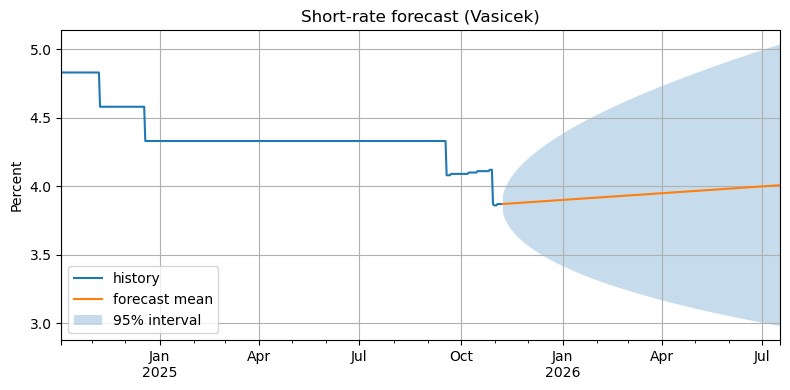

kappa=0.019  theta=14.600%  sigma=0.635  dt=0.00274 years/step
Final horizon forecast (mean, 95% CI) in %:
4.01  [2.98, 5.03]


In [3]:
# Short-rate forecasting with a Vasicek model using FRED data
# Requirements: pandas numpy statsmodels requests matplotlib (fredapi optional)

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

FRED_API_KEY = "a8837523b7c200b627e6e1f1a7275566"

# Preferred short-rate series (daily). We'll try in this order.
# EFFR: Effective Federal Funds Rate (percent, daily)
# DFF:  Effective Federal Funds Rate (legacy id)
# DGS3MO: 3M Treasury constant maturity (percent, daily)
SERIES_TRY = ["EFFR", "DFF", "DGS3MO"]

# ----------------------------
# Data fetch from FRED
# ----------------------------
def _fetch_series_requests(series_id: str, start: str = "1990-01-01") -> pd.Series:
    import requests
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": start,
    }
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    obs = r.json().get("observations", [])
    idx = pd.to_datetime([o["date"] for o in obs])
    vals = [None if o["value"] in (".", "") else float(o["value"]) for o in obs]
    s = pd.Series(vals, index=idx, name=series_id, dtype="float64")
    return s

def _fetch_series_fredapi(series_id: str, start: str = "1990-01-01") -> pd.Series:
    from fredapi import Fred
    fred = Fred(api_key=FRED_API_KEY)
    s = fred.get_series(series_id, observation_start=start)
    s.index = pd.to_datetime(s.index)
    s.name = series_id
    return s.astype("float64")

def get_short_rate(start="1990-01-01") -> pd.Series:
    # try fredapi else requests
    try:
        import fredapi  # noqa: F401
        use_fredapi = True
    except Exception:
        use_fredapi = False

    last_err = None
    for sid in SERIES_TRY:
        try:
            s = _fetch_series_fredapi(sid, start) if use_fredapi else _fetch_series_requests(sid, start)
            if not use_fredapi:
                time.sleep(0.1)
            s = s.dropna()
            if s.empty:
                continue
            return s.rename("short_rate_pct")
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Failed to fetch any short-rate series. Last error: {last_err}")

# ----------------------------
# Vasicek estimation utilities
# ----------------------------
def estimate_vasicek_ols(r: pd.Series) -> Tuple[float, float, float, float]:
    """
    Estimate Vasicek from discrete AR(1): r_{t+1} = a + b r_t + e_t
    Convert to continuous-time params:
      b = exp(-kappa*dt), a = theta*(1 - b),
      Var(e_t) = (sigma^2 / (2*kappa)) * (1 - exp(-2*kappa*dt))
    Returns (kappa, theta, sigma, dt_years).
    """
    r = r.asfreq("D").ffill()  # daily calendar frequency
    r = r.dropna()
    if len(r) < 260:
        raise ValueError("Need at least ~1 year of data at daily frequency.")

    # Compute average dt in years using actual date gaps
    days = np.diff(r.index.values.astype("datetime64[D]")).astype(int)
    mean_days = float(np.mean(days))
    dt = mean_days / 365.25  # years per step

    r_t = r.iloc[:-1].values
    r_tp1 = r.iloc[1:].values
    X = np.column_stack([np.ones_like(r_t), r_t])
    beta_hat = np.linalg.lstsq(X, r_tp1, rcond=None)[0]
    a_hat, b_hat = float(beta_hat[0]), float(beta_hat[1])

    # Mapping to continuous-time
    if not (0 < b_hat < 1.1):  # guard; mild tolerance
        b_hat = max(1e-6, min(b_hat, 0.999999))

    kappa = -np.log(b_hat) / dt
    theta = a_hat / (1.0 - b_hat)

    # Residual variance and sigma
    resid = r_tp1 - (a_hat + b_hat * r_t)
    s2 = float(np.var(resid, ddof=2))  # discrete residual variance
    denom = 1.0 - np.exp(-2.0 * kappa * dt)
    sigma = np.sqrt(max(1e-16, (2.0 * kappa * s2) / denom))

    return kappa, theta, sigma, dt

def vasicek_forecast_path(r0: float, horizon_steps: int, dt: float,
                          kappa: float, theta: float, sigma: float) -> pd.DataFrame:
    """
    Closed-form mean and variance at each step for the OU process.
    Returns DataFrame with columns ['mean','std','lower','upper'] in percent units.
    """
    hs = np.arange(1, horizon_steps + 1, dtype=float)
    exp_term = np.exp(-kappa * hs * dt)
    mean = theta + (r0 - theta) * exp_term
    var = (sigma**2) / (2.0 * kappa) * (1.0 - np.exp(-2.0 * kappa * hs * dt))
    std = np.sqrt(var)
    # 95% pointwise intervals
    z = 1.96
    lower = mean - z * std
    upper = mean + z * std
    return pd.DataFrame({"mean": mean, "std": std, "lower": lower, "upper": upper})

# ----------------------------
# End-to-end driver
# ----------------------------
def forecast_short_rate(
    start: str = "1990-01-01",
    history_years: int = 15,
    steps_ahead: int = 252,   # ~1y if daily steps
    plot: bool = True
):
    # 1) data
    sr = get_short_rate(start=start)  # percent
    sr = sr.loc[sr.index >= (pd.Timestamp.today().normalize() - pd.DateOffset(years=history_years))]
    sr = sr.asfreq("D").ffill()

    # 2) estimate Vasicek
    kappa, theta, sigma, dt = estimate_vasicek_ols(sr)

    # 3) forecasts
    r0 = float(sr.iloc[-1])
    path = vasicek_forecast_path(r0, steps_ahead, dt, kappa, theta, sigma)
    idx = pd.date_range(start=sr.index[-1] + pd.offsets.Day(), periods=steps_ahead, freq="D")
    path.index = idx
    path_pct = path  # already in percent units because input r0, theta are percents

    # 4) optional plot
    if plot:
        plt.figure(figsize=(8, 4))
        sr.tail(400).plot(label="history")
        path_pct["mean"].plot(label="forecast mean")
        plt.fill_between(path_pct.index, path_pct["lower"], path_pct["upper"], alpha=0.25, label="95% interval")
        plt.title("Short-rate forecast (Vasicek)")
        plt.ylabel("Percent")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # print quick summary
    print(f"kappa={kappa:.3f}  theta={theta:.3f}%  sigma={sigma:.3f}  dt={dt:.5f} years/step")
    print("Final horizon forecast (mean, 95% CI) in %:")
    last = path_pct.iloc[-1]
    print(f"{last['mean']:.2f}  [{last['lower']:.2f}, {last['upper']:.2f}]")

    return {
        "short_rate_series_pct": sr,
        "params": {"kappa": kappa, "theta_pct": theta, "sigma": sigma, "dt_years": dt},
        "forecast_path_pct": path_pct
    }

# ----------------------------
# Example
# ----------------------------
if __name__ == "__main__":
    out = forecast_short_rate(
        start="1990-01-01",
        history_years=15,
        steps_ahead=252,   # ~1 year of daily steps
        plot=True
    )

In [9]:
# Parametric short-rate modeling with FRED ingestion
# Self-contained for a Jupyter notebook.
# Dependencies: numpy, pandas, requests, scipy (optional but recommended)

import os
import math
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import requests

try:
    from scipy.stats import ncx2, norm
except Exception:
    ncx2 = None
    norm = None
    warnings.warn("scipy not found. CIR exact terminal sampling and normal CIs disabled.")

# ---------- Configuration ----------
# You can hardcode your key here or set env var FRED_API_KEY
FRED_API_KEY = os.getenv("FRED_API_KEY", "a8837523b7c200b627e6e1f1a7275566")

# ---------- Data ingestion ----------

def fetch_fred_series(
    series_id: str = "FEDFUNDS",
    fred_api_key: Optional[str] = None,
    start: Optional[str] = None,
    end: Optional[str] = None,
    freq: str = "M",
) -> pd.Series:
    """
    Download a FRED time series and return as pandas Series of decimals.
    Values returned by FRED are in percent; this converts to decimals.
    freq: 'B' business daily, 'W' weekly, 'M' month-end.
    """
    key = fred_api_key or FRED_API_KEY
    if not key:
        raise ValueError("Set FRED_API_KEY or pass fred_api_key.")
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {"series_id": series_id, "api_key": key, "file_type": "json"}
    if start:
        params["observation_start"] = start
    if end:
        params["observation_end"] = end
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    js = r.json()
    obs = js.get("observations", [])
    if not obs:
        raise RuntimeError("No observations from FRED.")
    df = pd.DataFrame(obs)
    df = df[df["value"] != "."].copy()
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    s = pd.Series(df["value"].values, index=df["date"], name=series_id)
    s = s.astype(float) / 100.0  # percent -> decimal
    f = freq.upper()
    if f == "B":
        s = s.resample("B").last().ffill()
    elif f == "W":
        s = s.resample("W").last().ffill()
    elif f == "M":
        s = s.resample("M").last().ffill()
    else:
        raise ValueError("freq must be B, W, or M")
    return s

# ---------- Helpers ----------

def _dt_in_years(freq: str) -> float:
    f = freq.upper()
    if f == "B":
        return 1.0 / 252.0
    if f == "W":
        return 1.0 / 52.0
    if f == "M":
        return 1.0 / 12.0
    raise ValueError("Unsupported freq")

def _ols(y: np.ndarray, X: np.ndarray) -> Tuple[np.ndarray, float]:
    # X has columns including intercept; returns beta and residual variance
    XtX = X.T @ X
    beta = np.linalg.solve(XtX, X.T @ y)
    resid = y - X @ beta
    s2 = (resid @ resid) / (len(y) - X.shape[1])
    return beta, float(s2)

# ---------- Base class ----------

@dataclass
class ShortRateModel:
    kappa: float
    theta: float
    sigma: float
    freq: str = "M"

    def forecast_moments(self, horizon_years: float, r0: Optional[float] = None) -> Tuple[float, float]:
        raise NotImplementedError

    def sample_terminal(self, r0: float, horizon_years: float, n: int = 10000, rng: Optional[np.random.Generator] = None) -> np.ndarray:
        raise NotImplementedError

    def simulate_paths(self, r0: float, years: float, n_paths: int = 1000, rng: Optional[np.random.Generator] = None) -> pd.DataFrame:
        dt = _dt_in_years(self.freq)
        steps = max(1, int(round(years / dt)))
        rng = rng or np.random.default_rng()
        out = np.empty((steps + 1, n_paths))
        out[0, :] = r0
        r = np.full(n_paths, r0, dtype=float)
        for t in range(1, steps + 1):
            r = self._one_step(r, dt, rng)
            out[t, :] = r
        idx = pd.date_range(pd.Timestamp.today().normalize(), periods=steps + 1, freq=self.freq)
        return pd.DataFrame(out, index=idx)

    def _one_step(self, r_prev: np.ndarray, dt: float, rng: np.random.Generator) -> np.ndarray:
        raise NotImplementedError

# ---------- Vasicek (OU) ----------

@dataclass
class Vasicek(ShortRateModel):
    """
    dr_t = kappa (theta - r_t) dt + sigma dW_t
    Exact discrete-time transition is Gaussian:
    r_{t+Δ} | r_t ~ N( r_t e^{-κΔ} + θ(1 - e^{-κΔ}),  (σ^2/(2κ))(1 - e^{-2κΔ}) )
    """

    @staticmethod
    def fit(series: pd.Series, freq: str = "M") -> "Vasicek":
        r = series.dropna().astype(float).values
        dt = _dt_in_years(freq)
        # OLS on r_{t+Δ} = a + b r_t + ε
        y = r[1:]
        x = r[:-1]
        X = np.column_stack([np.ones_like(x), x])
        (a, b), s2 = _ols(y, X)
        if not (0 < b < 1):
            b = min(max(b, 1e-6), 0.999999)
        kappa = -math.log(b) / dt
        theta = a / (1.0 - b)
        var_eps = s2
        sigma = math.sqrt(var_eps * 2.0 * kappa / (1.0 - math.exp(-2.0 * kappa * dt)))
        return Vasicek(kappa=float(kappa), theta=float(theta), sigma=float(sigma), freq=freq)

    def forecast_moments(self, horizon_years: float, r0: Optional[float] = None) -> Tuple[float, float]:
        if r0 is None:
            raise ValueError("Provide r0 for forecasts.")
        k, th, s = self.kappa, self.theta, self.sigma
        e = math.exp(-k * horizon_years)
        mean = r0 * e + th * (1.0 - e)
        var = (s * s) * (1.0 - e * e) / (2.0 * k)
        return float(mean), float(var)

    def sample_terminal(self, r0: float, horizon_years: float, n: int = 10000, rng: Optional[np.random.Generator] = None) -> np.ndarray:
        rng = rng or np.random.default_rng()
        mean, var = self.forecast_moments(horizon_years, r0=r0)
        return rng.normal(loc=mean, scale=math.sqrt(var), size=n)

    def _one_step(self, r_prev: np.ndarray, dt: float, rng: np.random.Generator) -> np.ndarray:
        k, th, s = self.kappa, self.theta, self.sigma
        e = math.exp(-k * dt)
        mean = r_prev * e + th * (1.0 - e)
        var = (s * s) * (1.0 - e * e) / (2.0 * k)
        return mean + rng.normal(0.0, math.sqrt(var), size=r_prev.shape[0])

# ---------- CIR (nonnegative) ----------

@dataclass
class CIR(ShortRateModel):
    """
    dr_t = kappa (theta - r_t) dt + sigma sqrt(r_t) dW_t
    Terminal distribution is noncentral chi-square if Feller condition holds.
    """

    @staticmethod
    def fit(series: pd.Series, freq: str = "M") -> "CIR":
        r = series.dropna().astype(float).values
        if np.any(r < 0):
            raise ValueError("CIR requires nonnegative rates.")
        dt = _dt_in_years(freq)
        # Quasi-ML via log-linearization of conditional mean
        # E[r_{t+Δ}|r_t] = θ + (r_t - θ) e^{-κΔ}
        y = r[1:]
        x = r[:-1]
        # Regress y on [1, x]
        X = np.column_stack([np.ones_like(x), x])
        (a, b), s2 = _ols(y, X)
        b = min(max(b, 1e-6), 0.999999)
        kappa = -math.log(b) / dt
        theta = a / (1.0 - b)
        # Sigma from conditional variance approx Var(y|x) ≈ (σ^2 / κ)(x) (1 - e^{-κΔ})^2 + (σ^2 θ / (2κ))(1 - e^{-κΔ})^2
        # Use method of moments on residuals var ~ c0 + c1*x
        resid = y - (a + b * x)
        v = resid * resid
        Z = np.column_stack([np.ones_like(x), x])
        (c0, c1), _ = _ols(v, Z)
        A = (1.0 - math.exp(-kappa * dt)) ** 2
        # Solve crude system: c0 ≈ (sigma^2 * theta / (2kappa)) * A,  c1 ≈ (sigma^2 / kappa) * A
        sigma_sq_over_k = max(c1 / max(A, 1e-12), 1e-12)
        sigma_sq = sigma_sq_over_k * kappa
        sigma_from_c0 = max((c0 / max(A, 1e-12)) * (2.0 * kappa) / max(theta, 1e-12), 1e-12)
        sigma = math.sqrt(max(0.5 * (sigma_sq + sigma_from_c0), 1e-12))
        return CIR(kappa=float(kappa), theta=float(theta), sigma=float(sigma), freq=freq)

    def forecast_moments(self, horizon_years: float, r0: Optional[float] = None) -> Tuple[float, float]:
        if r0 is None:
            raise ValueError("Provide r0 for forecasts.")
        k, th, s = self.kappa, self.theta, self.sigma
        e = math.exp(-k * horizon_years)
        mean = th + (r0 - th) * e
        var = (r0 * s * s * e * (1.0 - e) / k) + (th * s * s * (1.0 - e) ** 2 / (2.0 * k))
        return float(mean), float(var)

    def sample_terminal(self, r0: float, horizon_years: float, n: int = 10000, rng: Optional[np.random.Generator] = None) -> np.ndarray:
        k, th, s = self.kappa, self.theta, self.sigma
        c = (4.0 * k * th) / (s * s + 1e-16)
        gamma = (4.0 * k * math.exp(-k * horizon_years)) / (s * s * (1.0 - math.exp(-k * horizon_years)) + 1e-16)
        lam = r0 * gamma
        if ncx2 is None:
            # Fallback: Euler-Maruyama with small step
            rng = rng or np.random.default_rng()
            steps = max(100, int(100 * horizon_years))
            dt = horizon_years / steps
            r = np.full(n, r0, float)
            for _ in range(steps):
                r = r + k * (th - r) * dt + s * np.sqrt(np.clip(r, 0.0, None)) * rng.normal(0.0, math.sqrt(dt), size=n)
                r = np.clip(r, 0.0, None)
            return r
        # Exact: r_T ~ (σ^2(1-e^{-κT})/(4κ)) * χ'^2_{c}(λ)
        scale = (s * s * (1.0 - math.exp(-k * horizon_years))) / (4.0 * k)
        rng = rng or np.random.default_rng()
        x = ncx2.rvs(df=c, nc=lam, size=n, random_state=rng)
        return scale * x

    def _one_step(self, r_prev: np.ndarray, dt: float, rng: np.random.Generator) -> np.ndarray:
        # Exact one-step using noncentral chi-square if available, else EM
        if ncx2 is None:
            k, th, s = self.kappa, self.theta, self.sigma
            r = r_prev + k * (th - r_prev) * dt + s * np.sqrt(np.clip(r_prev, 0.0, None)) * rng.normal(0.0, math.sqrt(dt), size=r_prev.shape[0])
            return np.clip(r, 0.0, None)
        k, th, s = self.kappa, self.theta, self.sigma
        c = (4.0 * k * th) / (s * s + 1e-16)
        gamma = (4.0 * k * np.exp(-k * dt)) / (s * s * (1.0 - np.exp(-k * dt)) + 1e-16)
        lam = r_prev * gamma
        scale = (s * s * (1.0 - math.exp(-k * dt))) / (4.0 * k)
        x = ncx2.rvs(df=c, nc=lam, size=r_prev.shape[0], random_state=rng)
        return scale * x

# ---------- Stress utilities ----------

@dataclass
class ShockSpec:
    add_bp: float = 0.0          # add to r0 in basis points
    kappa_mult: float = 1.0      # multiply kappa
    theta_add_bp: float = 0.0    # add to theta in bp
    sigma_mult: float = 1.0      # multiply sigma

def apply_shock(model: ShortRateModel, r0: float, shock: ShockSpec) -> Tuple[ShortRateModel, float]:
    k = model.kappa * shock.kappa_mult
    th = model.theta + shock.theta_add_bp / 10000.0
    s = model.sigma * shock.sigma_mult
    r0s = r0 + shock.add_bp / 10000.0
    model_shocked = type(model)(kappa=float(k), theta=float(th), sigma=float(s), freq=model.freq)
    return model_shocked, r0s

# ---------- Convenience wrappers ----------

def calibrate_model(
    series_id: str = "FEDFUNDS",
    model: str = "vasicek",
    start: Optional[str] = None,
    end: Optional[str] = None,
    freq: str = "M",
    fred_api_key: Optional[str] = None,
) -> Tuple[ShortRateModel, float, pd.Series]:
    s = fetch_fred_series(series_id, fred_api_key, start, end, freq)
    r0 = float(s.iloc[-1])
    if model.lower() == "vasicek":
        m = Vasicek.fit(s, freq=freq)
    elif model.lower() == "cir":
        m = CIR.fit(s, freq=freq)
    else:
        raise ValueError("model must be 'vasicek' or 'cir'")
    return m, r0, s

def forecast_distribution(
    m: ShortRateModel,
    r0: float,
    horizon_years: float = 2.0,
    n: int = 100_000,
    rng: Optional[np.random.Generator] = None,
) -> Tuple[np.ndarray, float, float]:
    samp = m.sample_terminal(r0=r0, horizon_years=horizon_years, n=n, rng=rng)
    mu = float(np.mean(samp))
    sd = float(np.std(samp, ddof=1))
    return samp, mu, sd

def normal_ci(mean: float, var: float, level: float = 0.95) -> Tuple[float, float]:
    if norm is None:
      # 1.96 fallback
      z = 1.959963984540054
    else:
      z = float(norm.ppf(0.5 + level / 2.0))
    s = math.sqrt(max(var, 0.0))
    return mean - z * s, mean + z * s


s = fetch_fred_series("FEDFUNDS", start="2000-01-01", end=None, freq="M")
vas = Vasicek.fit(s, freq="M")
r0 = float(s.iloc[-1])
mean2y, var2y = vas.forecast_moments(horizon_years=2.0, r0=r0)
ci_lo, ci_hi = normal_ci(mean2y, var2y, 0.95)
samp, mu, sd = forecast_distribution(vas, r0, 2.0, n=200_000)

vas_s, r0_s = apply_shock(vas, r0, ShockSpec(add_bp=100, sigma_mult=1.25))
m_s, v_s = vas_s.forecast_moments(2.0, r0=r0_s)
ci_s = normal_ci(m_s, v_s)

/var/folders/_3/ss5_zy_50db0d2vmg4y3lzlr0000gn/T/ipykernel_90796/199231762.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.resample("M").last().ffill()


/var/folders/_3/ss5_zy_50db0d2vmg4y3lzlr0000gn/T/ipykernel_90796/199231762.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.resample("M").last().ffill()
/var/folders/_3/ss5_zy_50db0d2vmg4y3lzlr0000gn/T/ipykernel_90796/199231762.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range(pd.Timestamp.today().normalize(), periods=steps + 1, freq=self.freq)


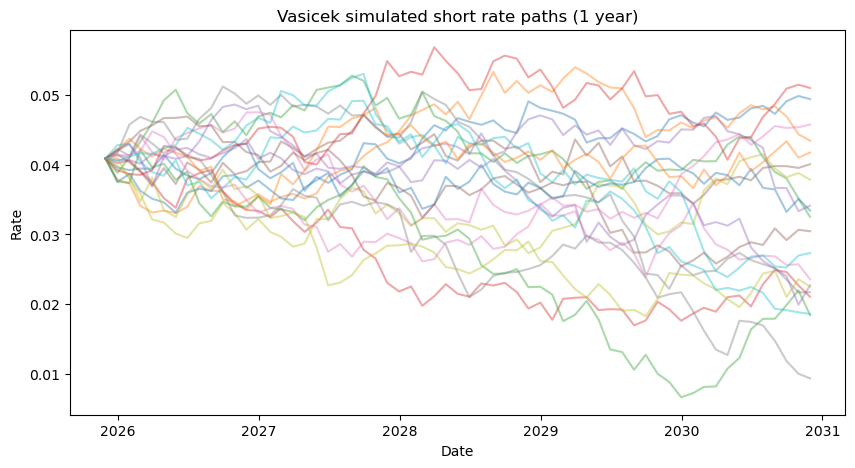

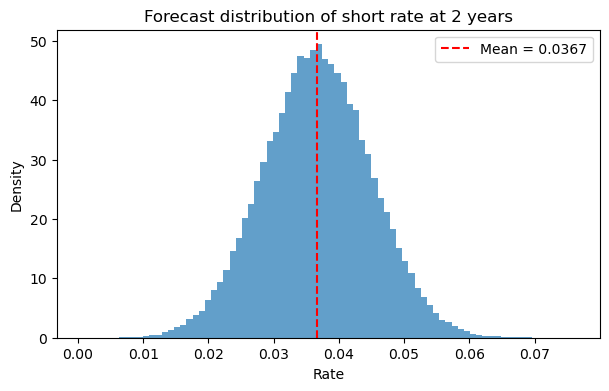

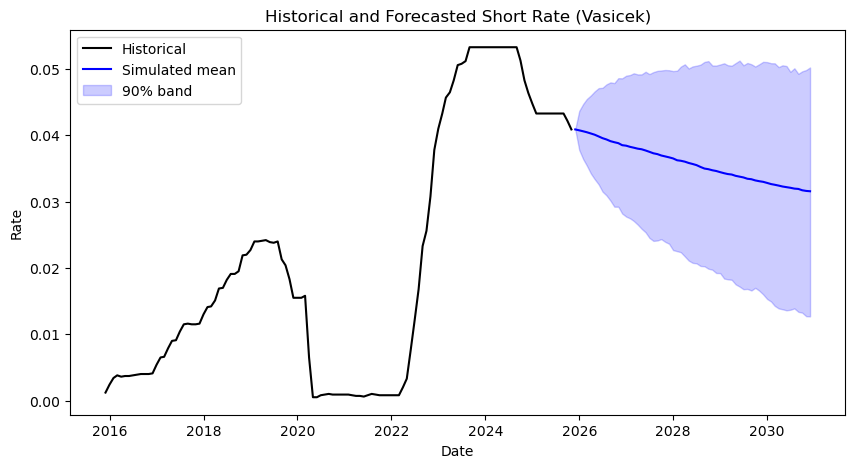

In [15]:
import matplotlib.pyplot as plt

model, r0, series = calibrate_model("FEDFUNDS", model="vasicek", start="2000-01-01", freq="M")

# 2. Simulate future paths (e.g., 5 years ahead, 1000 paths)
paths = model.simulate_paths(r0, years=5.0, n_paths=1000)





# 3. Plot a few sample paths
plt.figure(figsize=(10,5))
plt.plot(paths.iloc[:, :20], alpha=0.4)
plt.title("Vasicek simulated short rate paths (1 year)")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()





# 4. Forecast distribution at 2 years
samples, mu, sd = forecast_distribution(model, r0, horizon_years=2.0, n=100000)




# 5. Plot histogram of terminal distribution
plt.figure(figsize=(7,4))
plt.hist(samples, bins=80, density=True, alpha=0.7)
plt.axvline(mu, color="red", linestyle="--", label=f"Mean = {mu:.4f}")
plt.title("Forecast distribution of short rate at 2 years")
plt.xlabel("Rate")
plt.ylabel("Density")
plt.legend()
plt.show()





# 6. Historical vs simulated overlay
plt.figure(figsize=(10,5))
plt.plot(series[-120:], label="Historical", color="black")
plt.plot(paths.mean(axis=1), label="Simulated mean", color="blue")
plt.fill_between(paths.index, paths.quantile(0.05, axis=1), paths.quantile(0.95, axis=1),
                 color="blue", alpha=0.2, label="90% band")
plt.title("Historical and Forecasted Short Rate (Vasicek)")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend()
plt.show()